Hymenoptera Classification <br>
By: Lie Reubensto

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.keras.applications import MobileNetV2

In [2]:
# Load dataset
train_path = "./hymenoptera_data/train"
val_path = "./hymenoptera_data/val"

batch_size = 16
img_size = (128, 128)

train_dataset = image_dataset_from_directory(train_path, shuffle=False, batch_size=batch_size, image_size=img_size)
val_dataset = image_dataset_from_directory(val_path, shuffle=True, seed=42, batch_size=batch_size, image_size=img_size)

Found 245 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


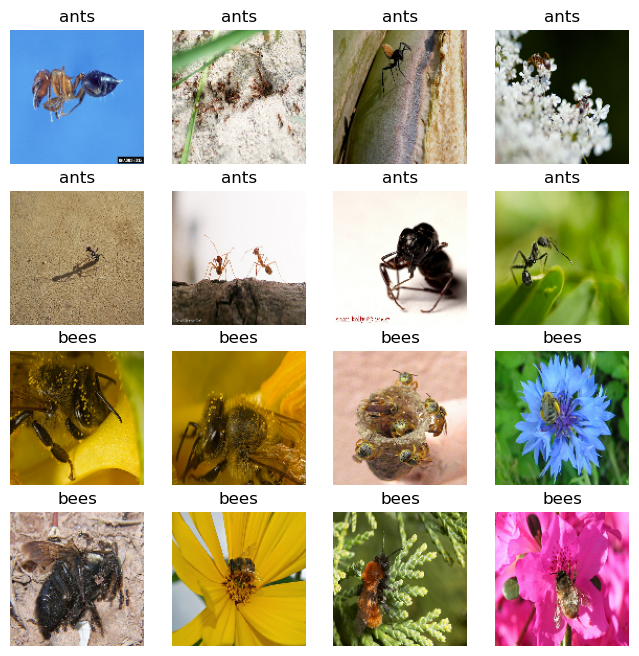

In [3]:
class_names = train_dataset.class_names
num_classes = len(train_dataset.class_names)
images_per_class = 8  # Number of images per class
total_images = num_classes * images_per_class

# Dictionary to store images for each class
images_by_class = {i: [] for i in range(num_classes)}

# Gather 8 images from each class
for image, label in train_dataset:
    label = label.numpy()
    for i in range(len(label)):
        class_idx = label[i]
        if len(images_by_class[class_idx]) < images_per_class:
            images_by_class[class_idx].append(image[i])
    # Stop when we have enough images
    if all(len(images) == images_per_class for images in images_by_class.values()):
        break

# Plot
plt.figure(figsize=(8, 8))
count = 0
for class_idx in images_by_class:
    for img in images_by_class[class_idx]:
        ax = plt.subplot(4, 4, count + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_names[class_idx])
        plt.axis("off")
        count += 1

plt.show()

In [4]:
# Split validation dataset to validation and testing dataset
val_batches = cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 7)
val_dataset = val_dataset.skip(val_batches // 7)
print(f'Val Batches: {cardinality(val_dataset)}')
print(f'Test Batches: {cardinality(test_dataset)}')

Val Batches: 9
Test Batches: 1


In [5]:
# Autotuning
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=autotune)
val_dataset = val_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

In [6]:
# Base model from the pre-trained model for RGB images
img_shape = img_size + (3,) # 3 channels of color (RGB)
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

In [7]:
# Feature extraction in transfer learning example
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 4, 4, 1280)


In [8]:
# Set base model to not trainable
base_model.trainable = False

In [9]:
# Model for predictions
input = Input(shape=img_shape)
journey = tf.keras.applications.mobilenet_v2.preprocess_input(input)
journey = base_model(journey, training=False)
journey = layers.GlobalMaxPooling2D()(journey)
journey = layers.Dropout(0.5)(journey)
output = layers.Dense(1, activation="sigmoid")(journey)
curr_model = Model(input, output)

In [10]:
# Summary curr_model
curr_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 128, 128, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 128, 128, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                             

In [11]:
# Trainable variables
len(curr_model.trainable_variables)

2

In [12]:
# Compile curr_model
curr_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
# Initial loss and accuracy
curr_model.evaluate(val_dataset)

9/9 [==============================] - 2s 62ms/step - loss: 2.0873 - accuracy: 0.4638


[2.08730149269104, 0.4637681245803833]

In [14]:
# Train the curr_model
init_epoch = 15
curr_history = curr_model.fit(train_dataset, epochs=init_epoch, validation_data=val_dataset, verbose=2)

Epoch 1/15
16/16 - 4s - loss: 4.4607 - accuracy: 0.5102 - val_loss: 1.5883 - val_accuracy: 0.4710 - 4s/epoch - 235ms/step
Epoch 2/15
16/16 - 2s - loss: 1.3232 - accuracy: 0.6204 - val_loss: 0.6336 - val_accuracy: 0.7029 - 2s/epoch - 109ms/step
Epoch 3/15
16/16 - 2s - loss: 1.6091 - accuracy: 0.6041 - val_loss: 0.3894 - val_accuracy: 0.8478 - 2s/epoch - 102ms/step
Epoch 4/15
16/16 - 2s - loss: 0.6371 - accuracy: 0.7959 - val_loss: 0.2009 - val_accuracy: 0.9130 - 2s/epoch - 109ms/step
Epoch 5/15
16/16 - 2s - loss: 0.5587 - accuracy: 0.8000 - val_loss: 0.2236 - val_accuracy: 0.9203 - 2s/epoch - 106ms/step
Epoch 6/15
16/16 - 2s - loss: 0.5188 - accuracy: 0.8245 - val_loss: 0.2206 - val_accuracy: 0.9203 - 2s/epoch - 106ms/step
Epoch 7/15
16/16 - 2s - loss: 0.3397 - accuracy: 0.8857 - val_loss: 0.1655 - val_accuracy: 0.9275 - 2s/epoch - 106ms/step
Epoch 8/15
16/16 - 2s - loss: 0.5261 - accuracy: 0.8204 - val_loss: 0.2114 - val_accuracy: 0.9130 - 2s/epoch - 109ms/step
Epoch 9/15
16/16 - 2s - 

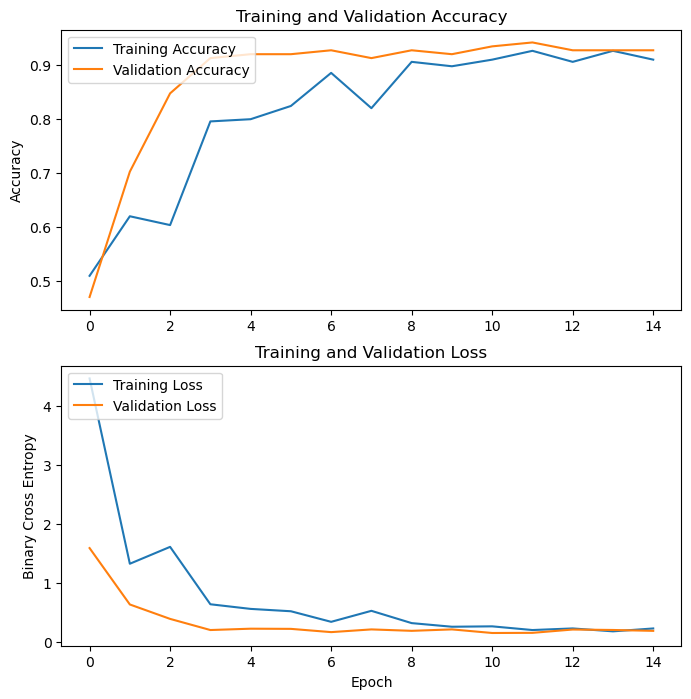

In [15]:
# Training-Validation result of curr_model
acc = curr_history.history['accuracy']
loss = curr_history.history['loss']
val_acc = curr_history.history['val_accuracy']
val_loss = curr_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend(loc='upper left')

plt.show()

Model Overfits towards the end

In [16]:
# Set base model to trainable
base_model.trainable = True

In [17]:
# curr_model summary
curr_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 128, 128, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 128, 128, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                             

In [18]:
# Fine Tuning the base_model
print(f"Number of layers in base model: {len(base_model.layers)}")

Number of layers in base model: 154


In [19]:
# Freezing the first determined amount of layers
start_ft = 152
for layer in base_model.layers[:start_ft]:
    layer.trainable = False

In [20]:
# Compile the fine tuning part of curr_model
curr_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
# Trainable variables from the new compiling
len(curr_model.trainable_variables)

4

In [22]:
# Train the fine-tuning curr_model
ft_epoch = 15
total_epoch =  init_epoch + ft_epoch
curr_history_ft = curr_model.fit(train_dataset, epochs=total_epoch, initial_epoch=curr_history.epoch[-1], validation_data=val_dataset, verbose=2)

Epoch 15/30
16/16 - 5s - loss: 0.6206 - accuracy: 0.8163 - val_loss: 0.1722 - val_accuracy: 0.9275 - 5s/epoch - 293ms/step
Epoch 16/30
16/16 - 2s - loss: 0.2321 - accuracy: 0.9388 - val_loss: 0.1775 - val_accuracy: 0.9130 - 2s/epoch - 110ms/step
Epoch 17/30
16/16 - 2s - loss: 0.2122 - accuracy: 0.9429 - val_loss: 0.2338 - val_accuracy: 0.9203 - 2s/epoch - 102ms/step
Epoch 18/30
16/16 - 2s - loss: 0.1296 - accuracy: 0.9592 - val_loss: 0.1988 - val_accuracy: 0.9420 - 2s/epoch - 108ms/step
Epoch 19/30
16/16 - 2s - loss: 0.1085 - accuracy: 0.9592 - val_loss: 0.2229 - val_accuracy: 0.9275 - 2s/epoch - 103ms/step
Epoch 20/30
16/16 - 2s - loss: 0.0997 - accuracy: 0.9633 - val_loss: 0.2593 - val_accuracy: 0.9275 - 2s/epoch - 109ms/step
Epoch 21/30
16/16 - 2s - loss: 0.0600 - accuracy: 0.9796 - val_loss: 0.2714 - val_accuracy: 0.9203 - 2s/epoch - 104ms/step
Epoch 22/30
16/16 - 2s - loss: 0.0754 - accuracy: 0.9796 - val_loss: 0.2088 - val_accuracy: 0.9348 - 2s/epoch - 106ms/step
Epoch 23/30
16/1

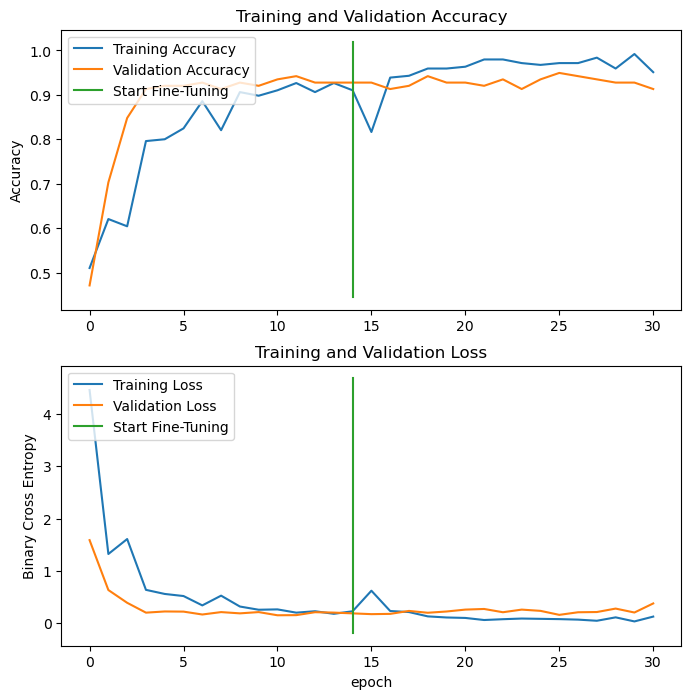

In [23]:
# Comparison of Training-Validation result of curr_model before and after fine-tuning
acc += curr_history_ft.history['accuracy']
loss += curr_history_ft.history['loss']
val_acc += curr_history_ft.history['val_accuracy']
val_loss += curr_history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([init_epoch-1,init_epoch-1], plt.ylim(), label='Start Fine-Tuning')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([init_epoch-1,init_epoch-1], plt.ylim(), label='Start Fine-Tuning')
plt.xlabel('epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend(loc='upper left')

plt.show()

Seems like the extra training of the unfrozen layers of the pre-trained model didn't help with the overfitting problem

In [24]:
# Evaluate model
curr_model.evaluate(test_dataset)

1/1 [==============================] - 0s 211ms/step - loss: 0.0149 - accuracy: 1.0000


[0.014886662364006042, 1.0]

Real Predictions:
 [4.7073016e-04 1.9343627e-09 2.4727476e-06 9.9905348e-01 1.6829706e-03
 6.9333746e-06 5.6799369e-08 9.9999809e-01 9.9996603e-01 2.6910338e-05
 3.0095664e-05 9.9966359e-01 6.2487819e-03 9.4904274e-01 1.3016181e-07
 9.7368109e-01]
Predictions:
 [0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1]
Real:
 [0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1]


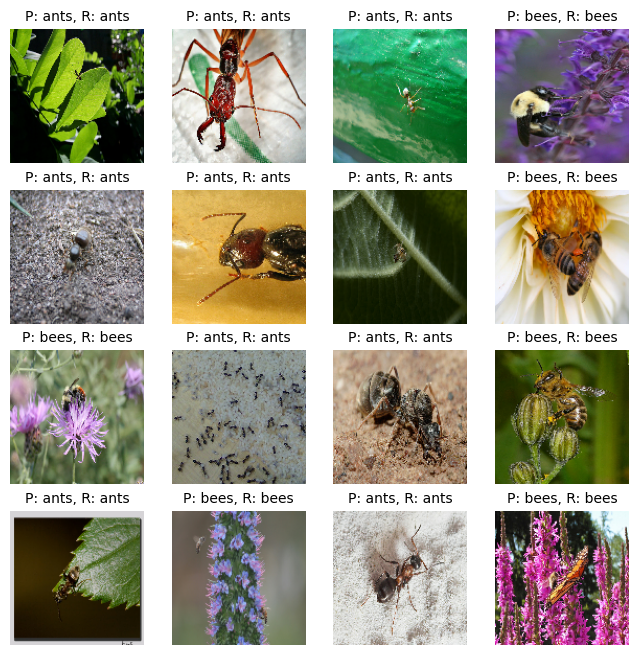

In [25]:
# Retrieve a batch of images from the test dataset
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = curr_model.predict_on_batch(image_batch).flatten()
print('Real Predictions:\n', predictions)

predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Real:\n', label_batch)

plt.figure(figsize=(8, 8))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"P: {class_names[predictions[i]]}, R: {class_names[label_batch[i]]}", fontsize=10)
  plt.axis("off")
plt.show()

In [26]:
# Clear Session
tf.keras.backend.clear_session()